# Some applications from NLA

## SVD 

- Any matrix can be presented in the form

$$A = U\Sigma V^*,$$

where $U$ and $V$ are unitary

$$ U^*U = I $$ 

and $\Sigma$ is diagonal.


### Application 1: topic modeling and latent semantic search 

- Given corpus of docs
- Topics extraction is required
- Bag-of-words model
- You need some embedding of the documents in $\mathbb{R}^n$

### Bag-of-words model

- Document is a set of words. We do not take into account words order
- Every topic is a set of the most representative words (terms)

### Term-document $A$

- Size of the matrix is $N_{docs} \times N_{terms}$
- How can we fill it?

### Possible options

- Element $(i, j)$ is the number of the  term in the $i$-th document
- Element $(i, j)$ is tf-idf for the $j$-th term and the $i$-th document

Tf-Idf is a product of

- tf – term frequency in the document

and

- idf = $\log \frac{|D|}{|\{ d \in D \mid t \in D \}|}$, so we have logarithm of ratio between total number of documents and number of documents with target term. 

**Q:** what property has matrix $A$?

## How SVD can help in construction of embedding?

- Given matrix $A$
- To get embedding in $\mathbb{R}^d$ we compute SVD for some rank $d$: $A \approx U\Sigma V^*$
- Matrix $U$ of size $N_{docs} \times d$, i.e. every document is reprepresented with some vector from $\mathbb{R}^d$
- Matrix $V$ of size $N_{terms} \times d$, i.e. every term is represented with some vector from $\mathbb{R}^d$ 

## Another interpretation

- If $d$ is a number of topics, then we get some distribution of terms and documents over topics
- We can extract the most relevant terms and documents to every topic and compare them
- Constructed embeddings can be used as input data for more advanced methods for classification/clustering

### Lets check how it works!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

### Load data

In [2]:
documents = []
with open("./data/test_articles.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        documents.append(text)
print("Total number of Documents:",len(documents))

Total number of Documents: 4551


### Example of document

In [3]:
documents[0]

"Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-financial crisis boom years. So it is tempting to think the bank, when asked by US Department of Justice to pay a large bill for polluting the financial system with mortgage junk between 2005 and 2007, should cough up, apologise and learn some humility. That is not the view of the chief executive, Jes Staley. Barclays thinks the DoJ’s claims are “disconnected from the facts” and that it has “an obligation to our shareholders, customers, clients and employees to defend ourselves against unreasonable allegations and demands.” The stance is possibly foolhardy, since going into open legal battle with the most powerful US prosecutor is risky, especially if you end up losing. But actually, some grudging respect for Staley and Barclays is in order. The US system for dishing out fines to errant banks for their mortgage sins has come to resemble a casino. The approach prefers settlements behind close

### Pre-processing of documents

In [4]:
news_df = pd.DataFrame({'document': documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:10])
# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


### Before vs. after

In [7]:
news_df.head()

,document,clean_doc
0,Barclays' defiance of US fines has merit Barcl...,barclays defiance fines merit barclays disgrac...
1,How big is Hillary Clinton's lead in the presi...,hillary clinton lead presidential race depends...
2,Zika’s greatest ally is human intransigence Th...,zika greatest ally human intransigence revenge...
3,Fight for the right: Cruz and Rubio spar in Ne...,fight right cruz rubio spar nevada trump chall...
4,Voting day: America finally goes the polls Can...,voting america finally goes polls candidates s...


### Construct matrix $A$

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer( 
max_features= 1000, # keep top 1000 terms 
)

# vectorizer = CountVectorizer(stop_words="english", max_features=100)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape

(4551, 1000)

In [10]:
X, X.nnz

(<4551x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 573008 stored elements in Compressed Sparse Row format>, 573008)

### Sparse SVD

- Computing SVD for dense and sparse matrices are different topics
- They are all will be covered in the course later...
- Here we need only first $k \ll n$ singular values and vectors
- Use special function from the SciPy library ```scipy.sparse.linalg``` 

In [11]:
u, sigma, v = spsplin.svds(X.asfptype(), k=7)

### Check decreasing of the singular values

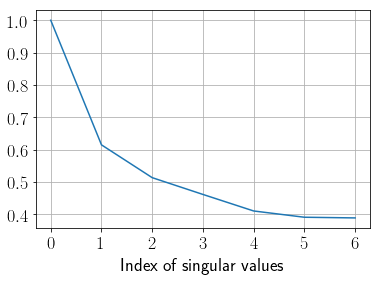

In [12]:
plt.plot(sigma[::-1]/sigma[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [13]:
terms = vectorizer.get_feature_names()
print(len(terms))
print(terms[:10])

1000
['ability', 'able', 'abortion', 'absolutely', 'abuse', 'access', 'according', 'account', 'accounts', 'accused']


### Topics and the most relevant terms for them

In [14]:
for i, comp in enumerate(v):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print("Word: {}, score: {}".format(t[0], t[1]))

Topic 0: 
Word: film, score: 0.3656734945881006
Word: brexit, score: 0.1846730855774056
Word: referendum, score: 0.11700896768468072
Word: britain, score: 0.11602223312337931
Word: vote, score: 0.1083855496576591
Word: bank, score: 0.10578759114998446
Word: movie, score: 0.09341393099855391
Word: leave, score: 0.09289914679995512
Word: european, score: 0.09262517494601938
Word: films, score: 0.08979404340910904
Topic 1: 
Word: film, score: 0.4818601010831597
Word: films, score: 0.12827345663911527
Word: movie, score: 0.12233290423757137
Word: health, score: 0.11155345407668957
Word: director, score: 0.08994131563145655
Word: women, score: 0.0886989462832646
Word: hollywood, score: 0.07992089103100955
Word: said, score: 0.07752406099722453
Word: actor, score: 0.07039321940523914
Word: mental, score: 0.05821114078972286
Topic 2: 
Word: brexit, score: 0.23412251310245624
Word: britain, score: 0.1759014627357284
Word: referendum, score: 0.1571494028145353
Word: leave, score: 0.153475811359

### Topics and the most relevant documents for them

In [19]:
top_docs = np.argmax(u, axis=0)
print(top_docs)
for i, j in enumerate(top_docs):
    print("Topic {}".format(i))
    print(documents[j])
    print(" ")

[3116 2806 2414 2806 1057  464  658]
Topic 0
Public Service Awards 2016 health and wellbeing winner: Derventio Housing Trust “Quite often people are in hospital and they’ve got nothing: no food, no clothes, no toiletries,” says Kate Gillespie, Derventio Housing Trust’s strategic lead for its Healthy Futures initiative. “We get all that sorted out, so people at least have a bit of dignity when they are discharged.” That’s just the start of the scheme’s work with homeless people due to leave hospital. Many have multiple, complex needs, such as mental health problems and addictions, and are trapped in a vicious cycle of ongoing health issues and repeat admissions. Over a 12-week period, staff work intensively to find housing for patients, settle them into their new homes and help them live independently – while making better use of primary care, rather than relying disproportionately on acute services. “Sometimes it’s because they don’t manage their health, so they actually get ill enough

### Let us find the closest document to the given one

In [15]:
new_request_original = '''There were four minutes remaining and none of the Newcastle United fans had left. 
Even with their team a man down and four goals down, they stayed. 
Even with another reminder of how their well-intentioned manager, Steve Bruce, 
struggles to build on the good work of Rafa Benítez, 
they kept standing there, kept singing, defying the rain and the pain.'''

# removing everything except alphabets`
new_request = new_request_original.replace("[^a-zA-Z#]", " ")

# removing short words
new_request = ' '.join([w for w in new_request.split() if len(w)>3])

# make all text lowercase
new_request = new_request.lower()


# tokenization
tokenized_doc = new_request.split()

# remove stop-words
tokenized_doc = [item for item in tokenized_doc if item not in stop_words]

# de-tokenization
detokenized_request = ' '.join(tokenized_doc)

y = vectorizer.transform([detokenized_request]).toarray().T
y.shape, v.shape

((1000, 1), (7, 1000))

In [16]:
score = u @ (sigma[:, np.newaxis] * v.dot(y))
print(score.shape)
idx_best = np.argmax(score)
print(documents[idx_best])

(4551, 1)
Premier League: 10 things to look out for this weekend 1) Start of a tough run for the Hammers On the last day of the 2006-07 season Manchester United, who had won the title five days earlier, fielded a weakened side – Cristiano Ronaldo, Ryan Giggs, Paul Scholes, Rio Ferdinand and Nemanja Vidic were all left out of the starting XI – at Old Trafford against a West Ham team who needed at least a point to avoid relegation. Carlos Tevez, who was to join United a few weeks later, scored the only goal on the stroke of half-time. “They couldn’t have come to Old Trafford on a better day,” said Sir Alex Ferguson after the game. “We had already won the league and the edge was off our game.” There was also a 1-0 win in December 2001, against a wretchedly out-of-form United side that were completing a memorably horrific run of five defeats in seven league games. Those two games are the Hammers’ only highlights in a miserable run of top-flight visits to Old Trafford that now extends over 

In [17]:
print(sorted(score.ravel())[::-1][:10])

[0.22850264300163275, 0.2224687017524494, 0.2205193310135809, 0.2188700242191252, 0.21690355372317566, 0.21238936465431482, 0.21173369809348372, 0.2113787684318612, 0.210149194965566, 0.20858976610117363]


## Application 2: recommender systems

### What data do we have?

- Matrix user-item
- Elements of the matrix are ratings
- A lot of missing data

## How can we use SVD?

- Original paper [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Construct embeddings of users and items in some subspace of $\mathbb{R}^n$
- For known users preferences we can find the most relevant items in this subspace
- How can we compute it?

### Movielens dataset with ratings of movies

In [18]:
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Example of entry

In [19]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Set the list of preferences

In [63]:
best_movies = "american pie|dracula"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
12,Dracula: Dead and Loving It (1995),"Comedy, Horror"
1329,Blood For Dracula (Andy Warhol's Dracula) (1974),Horror
1339,Bram Stoker's Dracula (1992),"Horror, Romance"
2644,Dracula (1931),Horror
2645,Dracula (1958),Horror
2646,House of Dracula (1945),Horror
2653,Son of Dracula (1943),Horror
2706,American Pie (1999),Comedy


### Find the indices of the favourite films

In [64]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([12, 1329, 1339, 2644, 2645, 2646, 2653, 2706], dtype='int64', name='movieid')


### Create matrix with ratings

In [65]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Compute SVD

In [66]:
rank = 100
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Check decreasing of the singular values

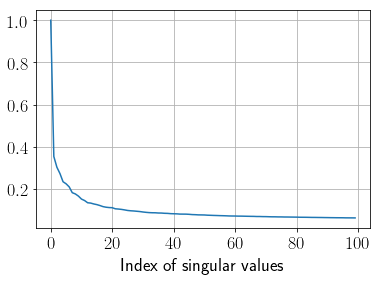

In [67]:
plt.plot(S[::-1] / S[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

### Compute correlations

In [68]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(100, 8)
(3953, 8)
(3953,)


### Compute resulting recommendations

In [69]:
top_n = 10
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.17523754 0.1335572  0.0907432  0.07835871 0.06997037 0.06870584
 0.06834026 0.06611486 0.0657754  0.06422745]


,movienm,genreid
movieid,,
2706,American Pie (1999),Comedy
2683,Austin Powers: The Spy Who Shagged Me (1999),Comedy
223,Clerks (1994),Comedy
2648,Frankenstein (1931),Horror
2644,Dracula (1931),Horror
2664,Invasion of the Body Snatchers (1956),"Horror, Sci-Fi"
1339,Bram Stoker's Dracula (1992),"Horror, Romance"
2694,Big Daddy (1999),Comedy
2858,American Beauty (1999),"Comedy, Drama"


## Generalizations 

- If we try to use context in our model, we have to introduce a new Gram matrix for scalar product. We have **hybrid model**, more details see in [this paper](https://arxiv.org/pdf/1802.06398.pdf)
- [Blog about recommender systems with technical details](https://www.eigentheories.com/archive.html#)